In [1]:
from torchvision import datasets, transforms
train_data = datasets.FashionMNIST(
	root="data",
	train=True,
	download=True,
	transform=transforms.ToTensor(),
)
test_data = datasets.FashionMNIST(
	root="data",
	train=False,
	download=True,
	transform=transforms.ToTensor(),
)
len(train_data), len(test_data)

(60000, 10000)

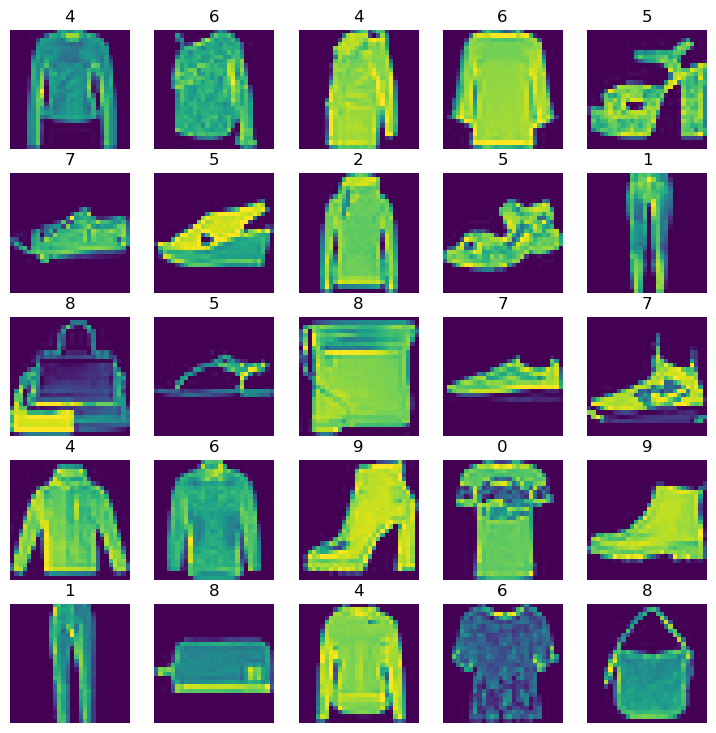

In [2]:
from matplotlib import pyplot as plt
from torch import randint

fig = plt.figure(figsize=(9,9))

for i in range(1, 26):
	random_img_no = randint(0, len(train_data),size=(1,)).item()
	img, lbl = train_data[random_img_no]
	img = img.squeeze()
	fig.add_subplot(5, 5, i)
	plt.imshow(img)
	plt.title(lbl)
	plt.axis(False)

In [3]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32
train_loader = DataLoader(
	dataset=train_data,
	batch_size=batch_size,
	shuffle=True,
)
test_loader = DataLoader(
	dataset=train_data,
	batch_size=batch_size,
	shuffle=False,
)
len(train_loader), len(test_loader)

(1875, 1875)

In [4]:
from torch import nn
import torch

class FashionCNN(nn.Module):
	def __init__(self, in_channels=3, hidden_units=9, out_channels=10, batch_size=32):
		super().__init__()
		self.batch_size = batch_size

		self.input_stack = nn.Sequential(
			nn.Conv2d(
				in_channels=in_channels,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=2,
			)
		)
		self.hidden_stack = nn.Sequential(
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=2,
			)
		)
		self.output_stack = nn.Sequential(
			nn.Flatten(),
			nn.Linear(
				in_features=hidden_units*6*6,
				out_features=out_channels,
			)
		)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.input_stack(x)
		# print(x.shape)
		x = self.hidden_stack(x)
		# print(x.shape)
		return self.output_stack(x)

	def accuray(self, preds: torch.Tensor, real: torch.Tensor) -> float:
		return torch.eq(preds.argmax(dim=1), real).sum().item()/self.batch_size
	

In [5]:

mdl = FashionCNN(
	hidden_units=8,
	in_channels=1,
	out_channels=10,
	batch_size=batch_size,
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	params=mdl.parameters(),
	lr=0.01,
)
mdl

FashionCNN(
  (input_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_stack): Sequential(
    (0): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=10, bias=True)
  )
)

In [6]:
epochs = 1

for epoch in range(epochs):

	for batch, (x, y) in enumerate(train_loader):
		mdl.train()
		preds = mdl(x)

		loss = loss_fn(preds, y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	mdl.eval()
	with torch.inference_mode():
		acc, loss = 0, 0
		for test_x, test_y in test_loader:
			test_preds = mdl(test_x)
			loss += loss_fn(test_preds, test_y)
			acc += mdl.accuray(test_preds, test_y)
		acc/=len(test_loader)
		loss/=len(test_loader)

		print(f"epoch:{epoch:<4} acc:{acc*100:.2f}{'%':<4} loss:{loss:.4f}")

epoch:0    acc:71.59%    loss:0.9302
